# Comparing by critical lifetime ratio (PHASOR part)
Simulating the lifetime decay from 3.07 to 2.5, for 20 points. Amplitude the same as before. Derive the index of separability to obtain critical
lifetime ratio.

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import fsolve

plt.style.use('seaborn-v0_8-deep')

In [2]:
from TCSPC import *

In [3]:
def phasor_eq_func_A_vary(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1,A2, tau1, tau2)
       Input: 
       A_tau_arr    parameter array A1,A2 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int(len(A_tau_arr)/2) #number of components
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) #pure multiexponential
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    A_sum = 1-np.sum(A_tau_arr[:n]) #A1,...An sum to 1
    phasor_compare = phasor_test.real[0:2*n-1]-phasor.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    return [A_sum]+list(phasor_compare) #

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_compare = phasor_test.real[0:2*n-1]-phasor.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    return phasor_compare

def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)

In [4]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])   #EGFP object
EGFP.tau = [2.43, 6]
EGFP.phasor_fft()
phasor_solve_num(EGFP.phasor,[EGFP.amp[0],*EGFP.tau])

array([0.9707458 , 2.68400296, 5.37283155])

In [5]:
tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.43,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])

C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [6]:
mean = np.mean(par_arr,axis = 1)
std = np.std(par_arr,axis = 1)

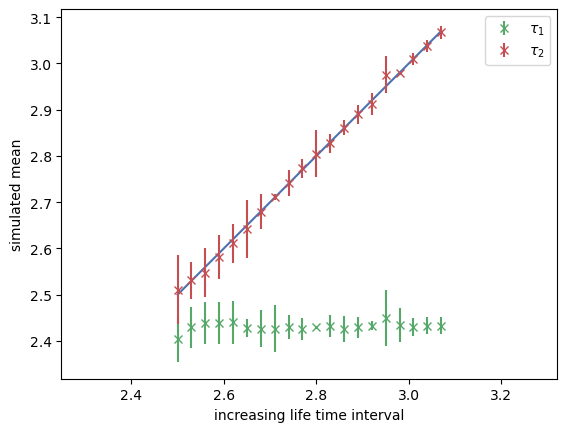

In [16]:
plt.figure()
plt.axis("equal")
plt.plot(tau_array,tau_array)
plt.errorbar(tau_array,mean[:,1],yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,mean[:,2],yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.title()
plt.xlabel("increasing life time interval")
plt.ylabel("simulated mean")
plt.legend()
plt.show()

## Separability

In [17]:
separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
for i in separability_kl:
    if i < 1: 
        print("separability_kl is ", i, ", it's nonseparatable.")
    else:
        print("separability_kl is ", i)

separability_kl is  0.15228968843221932 , it's nonseparatable.
separability_kl is  0.15759384679540137 , it's nonseparatable.
separability_kl is  0.16370297647838922 , it's nonseparatable.
separability_kl is  0.21722202031902477 , it's nonseparatable.
separability_kl is  0.26382303885250386 , it's nonseparatable.
separability_kl is  0.34360239950360555 , it's nonseparatable.
separability_kl is  0.40393265848886534 , it's nonseparatable.
separability_kl is  0.5140547770780342 , it's nonseparatable.
separability_kl is  0.5441720758208606 , it's nonseparatable.
separability_kl is  0.6329935156749834 , it's nonseparatable.
separability_kl is  0.7281187671810515 , it's nonseparatable.
separability_kl is  0.7270981481425036 , it's nonseparatable.
separability_kl is  0.7959991167902177 , it's nonseparatable.
separability_kl is  0.8513697869321375 , it's nonseparatable.
separability_kl is  0.950998821948757 , it's nonseparatable.
separability_kl is  0.7876102465772027 , it's nonseparatable.
se

## critical lifetime ratio

In [47]:
n_photon_arr = np.logspace(4,9,20).astype(int)
result_array = np.zeros((20,20,10,3))
for i in range(20):
    EGFP.n_photon = n_photon_arr[i]
    for j in range(20): 
        EGFP.tau = [2.43,tau_array[j]]
        for k in range(10): #no background
            EGFP.repeat_sim(10)
            phasor = EGFP.phasor_data[k]
            result_array[i,j,k] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])        

In [48]:
mean_new = np.mean(result_array,axis = 2)
std_new = np.std(result_array,axis = 2)

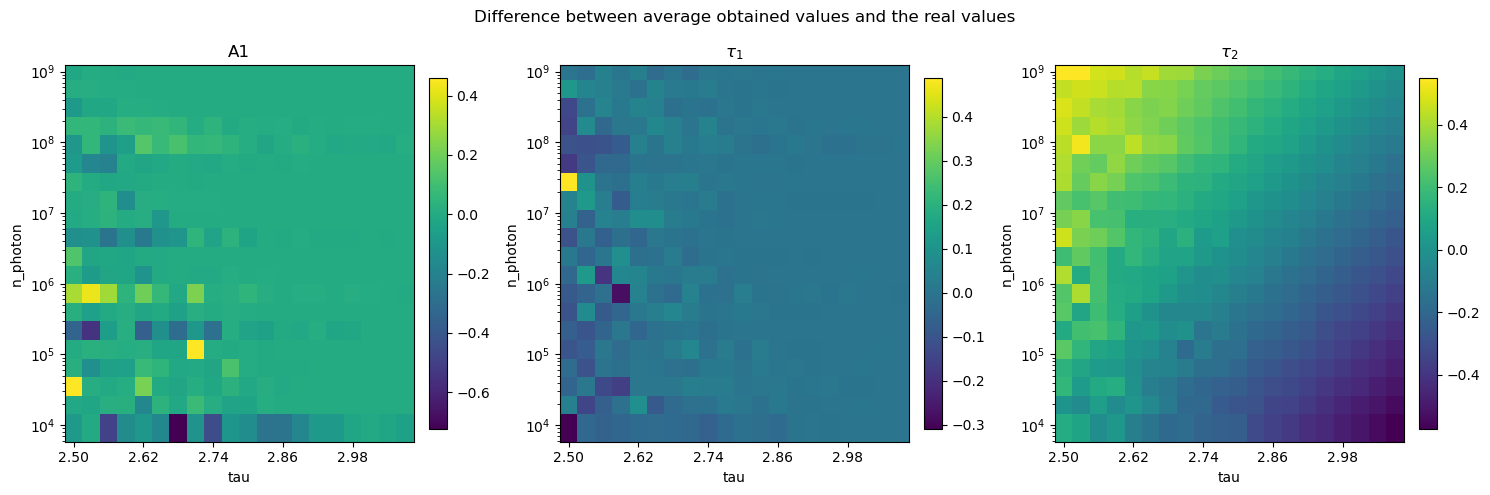

In [87]:
N,T2 = np.meshgrid(n_photon_arr,tau_array)
N,T1 = np.meshgrid(n_photon_arr,np.ones(20)*2.43)
N,A1 = np.meshgrid(n_photon_arr,np.ones(20)*0.497)
true = [A1,T1,T2]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Difference between average obtained values and the real values')
for i in range(3):
    cax = axs[i].pcolormesh(T2,N,mean_new[:,:,i]-true[i])
    axs[i].set_title('First Image')
    fig.colorbar(cax, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_yscale('log')
    axs[i].set_aspect('auto')
    axs[i].set_xticks(tau_array[::4])
    axs[i].set_xlabel(f'tau')
    axs[i].set_ylabel(f'n_photon')
    axs[i].set_title(['A1',r'$\tau_1$',r'$\tau_2$'][i])

plt.tight_layout()